In [2]:
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from qiskit_algorithms.optimizers import COBYLA
import itertools
from collections import Counter

# 参数定义
n = 2  # 作业数量
m = 3  # 机器数量
N = int(np.ceil(np.log2(m)))  # 二进制位数表示机器号
l = 2  # C_max 的二进制位数
p = np.array([[1, 2, 3], [2, 3, 1]])  # 处理时间矩阵
b = np.array([[0, 0], [1, 0], [0, 1]])  # 机器的二进制表示 (0, 1, 2)
W = [2]  # 不可用机器集合 (机器 2，对应 [0, 1])
K1 = 100  # 惩罚系数 1
P = 200  # 惩罚系数 2
num_qubits = n * N + l  # 总量子比特数


# 定义量子门函数
def append_multi_rzz_term(qc, qubits, gamma):
    """实现多体 Z 交互项 e^{-i \gamma Z_1 Z_2 ... Z_k}"""
    if len(qubits) == 0:
        return
    if len(qubits) == 1:
        qc.rz(2 * gamma, qubits[0])
        return
    for q in qubits[:-1]:
        qc.cx(q, qubits[-1])
    qc.rz(2 * gamma, qubits[-1])
    for q in reversed(qubits[:-1]):
        qc.cx(q, qubits[-1])


def append__z_term(qc, qubit, gamma):
    qc.rz(2 * gamma, qubit)


def append__zz_term(qc, qubit1, qubit2, gamma):
    qc.cx(qubit1, qubit2)
    qc.rz(2 * gamma, qubit2)
    qc.cx(qubit1, qubit2)


def append__mixer_term(qc, qubit, beta):
    qc.rx(2 * beta, qubit)


# H_1: -1/2 ∑_{h=0}^{l-1} 2^h Z_h
def get_cost_circuit_h1(gamma, qc):
    for h in range(l):
        coef = -0.5 * 2 ** h
        append__z_term(qc, n * N + h, gamma * coef)
    return qc


# H_2: K_1 ∑_{j∈W} ∑_{i=0}^{n-1} 1/2^N ∑_{S} (∏_{k∈S} (1 - 2 b_{jk})) (∏_{k∈S} Z_{ik})
def get_cost_circuit_h2(gamma, qc):
    all_combinations = list(itertools.chain(*(itertools.combinations(range(N), r) for r in range(N + 1))))
    for j in W:
        for i in range(n):
            for S in all_combinations:
                coef = K1 / (2 ** N)
                qubits = []
                for k in S:
                    coef *= (1 - 2 * b[j, k])
                    qubits.append(i * N + k)
                append_multi_rzz_term(qc, qubits, gamma * coef)
    return qc


# H_3: P ∑_{j=0}^{m-1} (C_j - C_max)^2
def get_cost_circuit_h3(gamma, qc):
    all_combinations = list(itertools.chain(*(itertools.combinations(range(N), r) for r in range(N + 1))))

    for j in range(m):
        # C_j^2: ∑_{i,i'} p_{ij} p_{i'j} 1/2^{2N} ∑_{S_i,S_{i'}} (...)
        for i in range(n):
            for i_prime in range(n):
                for S_i in all_combinations:
                    for S_i_prime in all_combinations:
                        coef = P * p[i, j] * p[i_prime, j] / (2 ** (2 * N))
                        qubits = []
                        for k in S_i:
                            coef *= (1 - 2 * b[j, k])
                            qubits.append(i * N + k)
                        for k in S_i_prime:
                            coef *= (1 - 2 * b[j, k])
                            qubits.append(i_prime * N + k)
                        count = Counter(qubits)
                        qubits_final = [q for q, cnt in count.items() if cnt % 2 == 1]
                        if len(qubits_final) > 0:
                            append_multi_rzz_term(qc, qubits_final, gamma * coef)

        # -2 C_j C_max: -2 ∑_{i} p_{ij} 1/2^{N-1} ∑_{S_i} (...) ∑_{h} 2^h + ∑_{i} p_{ij} 1/2^{N-1} ∑_{S_i} (...) ∑_{h} 2^h Z_h
        for i in range(n):
            for S_i in all_combinations:
                coef_base = P * p[i, j] / (2 ** (N - 1))
                qubits_S = []
                for k in S_i:
                    coef_base *= (1 - 2 * b[j, k])
                    qubits_S.append(i * N + k)
                for h in range(l):
                    coef = coef_base * 2 ** h
                    # -2 C_j term
                    append_multi_rzz_term(qc, qubits_S, -2 * gamma * coef)
                    # C_j Z_h term
                    qubits_combined = qubits_S + [n * N + h]
                    append_multi_rzz_term(qc, qubits_combined, 2 * gamma * coef)

        # C_max^2: 1/4 ∑_{h,h'} 2^h 2^{h'} Z_h Z_{h'} - 1/2 (∑_{h} 2^h) ∑_{h} 2^h Z_h
        for h in range(l):
            coef = -0.5 * P * (2 ** l - 1) * 2 ** h
            append__z_term(qc, n * N + h, gamma * coef)
            for h_prime in range(l):
                if h != h_prime:
                    coef = 0.25 * P * 2 ** h * 2 ** h_prime
                    append__zz_term(qc, n * N + h, n * N + h_prime, gamma * coef)

    return qc


# 混合器电路
def get_mixer_circuit(beta, qc):
    for i in range(num_qubits):
        append__mixer_term(qc, i, beta)
    return qc


# 反转比特序
def invert_counts(s):
    return s[::-1]


# 成本函数
def cost_function(params):
    beta, gamma = params[:len(params) // 2], params[len(params) // 2:]
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.h(range(num_qubits))
    for i in range(len(beta)):
        get_cost_circuit_h1(gamma[i], qc)
        get_cost_circuit_h2(gamma[i], qc)
        get_cost_circuit_h3(gamma[i], qc)
        get_mixer_circuit(beta[i], qc)
    qc.measure(range(num_qubits), range(num_qubits))

    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend, seed_simulator=10, shots=10000).result()
    counts = result.get_counts(qc)

    expectation = 0
    offset = P * sum((2 ** l - 1) ** 2 / 4 for _ in range(m))  # H_3 的常数项
    for bitstring, count in counts.items():
        bitstring = invert_counts(bitstring)
        prob = count / 10000
        z_h = np.array([int(bit) for bit in bitstring[n * N:]])
        s_ik = np.array([int(bit) for bit in bitstring[:n * N]]).reshape(n, N)

        E1 = np.sum([2 ** h * z_h[h] for h in range(l)])
        E2 = 0
        for j in W:
            for i in range(n):
                constant = 1
                for k in range(N):
                    constant *= (1 - (s_ik[i, k] - b[j, k]) ** 2)
                E2 += constant
        E2 = K1 * E2
        E3 = 0
        for j in range(m):
            load = 0
            for i in range(n):
                constant = 1
                for k in range(N):
                    constant *= (1 - (s_ik[i, k] - b[j, k]) ** 2)
                load += p[i, j] * constant
            c_max = np.sum([2 ** h * z_h[h] for h in range(l)])
            E3 += P * (load - c_max) ** 2

        E = E1 + E2 + E3
        expectation += E * prob

    return expectation + offset, counts


# 参数优化
def optimize_qaoa(params):
    def objective(params):
        expectation, _ = cost_function(params)
        return expectation

    optimizer = COBYLA(rhobeg=1.5, tol=1e-7)
    result = optimizer.minimize(fun=objective, x0=params)
    return result


# 插值法初始化函数
def interpolate_parameters(prev_params, p_old, p_new):
    if p_old == 0:
        return np.random.uniform(0, np.pi, p_new), np.random.uniform(0, 2 * np.pi, p_new)
    prev_beta = prev_params[:p_old]
    prev_gamma = prev_params[p_old:]
    new_beta = np.zeros(p_new)
    new_gamma = np.zeros(p_new)
    for i in range(p_new):
        t = i / (p_new - 1) if p_new > 1 else 0
        new_beta[i] = (1 - t) * prev_beta[0] + t * prev_beta[-1]
        new_gamma[i] = (1 - t) * prev_gamma[0] + t * prev_gamma[-1]
    return np.concatenate([new_beta, new_gamma])

In [3]:
# 主程序
import time

startTime = time.time()
min_energy = float('inf')
init_point = np.array([])
counts = {}
final_result = None

for p1 in range(1, 4):
    min_energy = 100000
    for k in range(10):
        print(f"第 {p1} 层，第 {k} 个参数")
        if k == 0 and p1 == 1:
            init_point_temp = np.concatenate([np.random.uniform(0, np.pi, p1),
                                              np.random.uniform(0, 2 * np.pi, p1)])
        elif k == 0:
            # 使用插值法从前一层生成新参数
            init_point_temp = interpolate_parameters(init_point, p1 - 1, p1)
        else:
            # 随机调整当前层的参数
            init_point_temp = init_point.copy()
            beta_p = np.random.uniform(0, np.pi)
            gamma_p = np.random.uniform(0, 2 * np.pi)
            init_point_temp = np.delete(init_point_temp, 2 * p1 - 1)
            init_point_temp = np.delete(init_point_temp, p1 - 1)
            init_point_temp = np.insert(init_point_temp, p1 - 1, beta_p)
            init_point_temp = np.insert(init_point_temp, 2 * p1 - 1, gamma_p)

        result = optimize_qaoa(init_point_temp)
        optimal_params = result.x
        energy, counts_temp = cost_function(result.x)

        if min_energy > energy:
            min_energy = energy
            init_point = optimal_params
            counts = counts_temp
            final_result = result
            print(f"New best energy: {min_energy}")
            print(f"Optimal parameters: {init_point}")

endTime = time.time()

第 1 层，第 0 个参数


C:\Users\李华宪\AppData\Local\Temp\ipykernel_31720\1749630776.py:138: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(qc, backend, seed_simulator=10, shots=10000).result()


New best energy: 3047.5035
Optimal parameters: [ 0.22348462 -0.7264212 ]
第 1 层，第 1 个参数
第 1 层，第 2 个参数
第 1 层，第 3 个参数
New best energy: 2907.9675000000007
Optimal parameters: [-0.45846338  9.30677617]
第 1 层，第 4 个参数
New best energy: 2604.6932000000006
Optimal parameters: [3.69738457 2.28554131]
第 1 层，第 5 个参数
第 1 层，第 6 个参数
第 1 层，第 7 个参数
第 1 层，第 8 个参数
第 1 层，第 9 个参数
第 2 层，第 0 个参数
New best energy: 3020.2191999999995
Optimal parameters: [2.4304227  5.74522753 3.95974942 1.72484911]
第 2 层，第 1 个参数
New best energy: 2563.7847
Optimal parameters: [2.43135759 3.00772168 3.95842689 7.19056789]
第 2 层，第 2 个参数
New best energy: 2522.3887999999997
Optimal parameters: [2.43145868 0.21247521 3.95839561 3.93036715]
第 2 层，第 3 个参数
第 2 层，第 4 个参数
New best energy: 2519.8642000000004
Optimal parameters: [3.93148883 1.79500822 3.95839598 3.1813738 ]
第 2 层，第 5 个参数
第 2 层，第 6 个参数
第 2 层，第 7 个参数
第 2 层，第 8 个参数
第 2 层，第 9 个参数
第 3 层，第 0 个参数
New best energy: 2525.8248999999996
Optimal parameters: [3.93151446 2.99992959 1.66667

优化时间： 282.3256070613861
Optimal parameters: [5.42983068 3.15577392 3.0799317  3.95839641 5.06431342 5.1645174 ]
Optimal value: 2501.697
Final expectation value: 2501.697
Final measurement counts: {'100110': 729, '011110': 713, '110110': 692, '010010': 683, '100010': 621, '001010': 574, '101110': 541, '000110': 521, '001110': 511, '111110': 498, '010110': 458, '011010': 452, '111010': 442, '110010': 436, '000010': 360, '101010': 328, '101100': 119, '110000': 100}


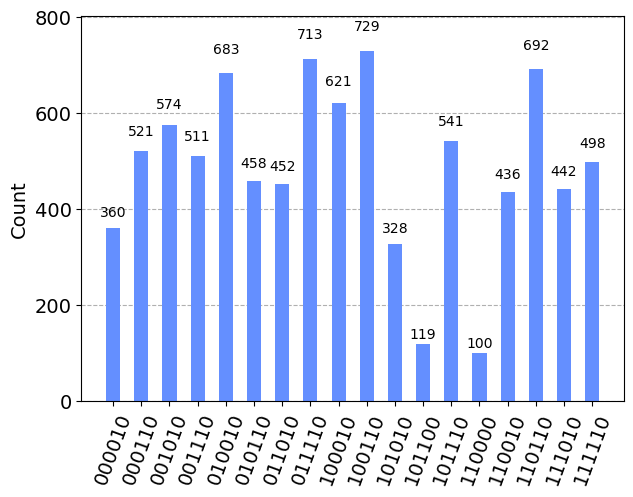

In [4]:
import warnings
from qiskit.visualization import plot_histogram

# 忽略弃用警告
warnings.filterwarnings("ignore", category=DeprecationWarning)
# 输出结果
print("优化时间：", endTime - startTime)
print("Optimal parameters:", final_result.x)
print("Optimal value:", final_result.fun)
# 使用最优参数运行量子电路并输出测量结果
final_expectation, final_counts = cost_function(final_result.x)
sorted_dict = {item[0][::-1]: item[1] for item in sorted(final_counts.items(), key=lambda item: item[1], reverse=True)}
# 过滤掉计数小于 100 的结果
filtered_dict = {key: value for key, value in sorted_dict.items() if value >= 100}
print("Final expectation value:", final_expectation)
print("Final measurement counts:", filtered_dict)
plot_histogram(filtered_dict)